# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Set-up-data" data-toc-modified-id="Set-up-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set up data</a></div><div class="lev2 toc-item"><a href="#Find-data-overlap" data-toc-modified-id="Find-data-overlap-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find data overlap</a></div><div class="lev2 toc-item"><a href="#Reduce-frequency-of-ground_df-for-1-to-1-comparison" data-toc-modified-id="Reduce-frequency-of-ground_df-for-1-to-1-comparison-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Reduce frequency of ground_df for 1-to-1 comparison</a></div><div class="lev2 toc-item"><a href="#Window-based-metrics" data-toc-modified-id="Window-based-metrics-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Window based metrics</a></div><div class="lev1 toc-item"><a href="#Decision-trees" data-toc-modified-id="Decision-trees-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Decision trees</a></div><div class="lev2 toc-item"><a href="#NSRDB-data" data-toc-modified-id="NSRDB-data-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>NSRDB data</a></div><div class="lev3 toc-item"><a href="#Default-tree" data-toc-modified-id="Default-tree-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Default tree</a></div><div class="lev3 toc-item"><a href="#Max-depth-tree" data-toc-modified-id="Max-depth-tree-412"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Max depth tree</a></div><div class="lev2 toc-item"><a href="#Test-on-NSRDB-data" data-toc-modified-id="Test-on-NSRDB-data-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Test on NSRDB data</a></div><div class="lev2 toc-item"><a href="#Test-on-ground-data" data-toc-modified-id="Test-on-ground-data-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test on ground data</a></div><div class="lev2 toc-item"><a href="#First-run" data-toc-modified-id="First-run-44"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>First run</a></div><div class="lev2 toc-item"><a href="#Repeat-on-1-min-data" data-toc-modified-id="Repeat-on-1-min-data-45"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Repeat on 1 min data</a></div>

# Introduction

This notebook will explore how closely NSRDB satellite data and RTC ground data agree on irradiance measurements.  We will also look at the agreement between modeled irradiance from NSRDB and that supplied by PVLIB.  Ideally we hope to see that measured irradiances and modeled irradiances are close to one another for both collection methods.  If the NSRDB and ground based RTC data are different, we hope that they are different on a similar scale.

# Load data

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pytz
import itertools
import pydotplus

import pvlib
import utils

import model_free

import concurrent.futures

np.set_printoptions(precision=4)
%matplotlib notebook

In [2]:
nsrdb_df = pd.read_pickle('./srrl_nsrdb_df.pkl')
ground_df = pd.read_pickle('./srrl_ground_df.pkl')

# Set up data

## Find data overlap

In [3]:
nsrdb_df.index = nsrdb_df.index.tz_convert('UTC')
ground_df.index = ground_df.index.tz_convert('UTC')

In [4]:
intersection = nsrdb_df.index.intersection(ground_df.index)
EARLIEST_IDX = intersection[0]
LATEST_IDX = intersection[-1]
print('NSRDB date range: {} -> {}'.format(nsrdb_df.index[0], nsrdb_df.index[-1]))
print('Ground date range: {} -> {}'.format(ground_df.index[0], ground_df.index[-1]))
print('Earliest intersection: {}, latest intersection: {}'.format(EARLIEST_IDX, LATEST_IDX))

NSRDB date range: 1998-01-01 00:00:00+00:00 -> 2015-12-31 23:30:00+00:00
Ground date range: 2009-01-01 07:01:00+00:00 -> 2015-01-01 06:59:00+00:00
Earliest intersection: 2009-01-01 07:30:00+00:00, latest intersection: 2015-01-01 06:30:00+00:00


In [5]:
intersection = intersection[intersection >= '01-01-2009']

## Reduce frequency of ground_df for 1-to-1 comparison

In [6]:
ground_df = ground_df.loc[intersection]

## Window based metrics

In [7]:
window = 3
nsrdb_df['abs_diff_ratio stat window mean'] = nsrdb_df['abs_diff_ratio stat'].rolling(window, center=True).mean().fillna(0)
nsrdb_df['abs_diff_ratio stat window std'] = nsrdb_df['abs_diff_ratio stat'].rolling(window, center=True).std().fillna(0)
nsrdb_df['abs_diff_ratio stat window max'] = nsrdb_df['abs_diff_ratio stat'].rolling(window, center=True).max().fillna(0)
nsrdb_df['abs_diff_ratio stat window min'] = nsrdb_df['abs_diff_ratio stat'].rolling(window, center=True).min().fillna(0)

In [8]:
window = 3
ground_df['abs_diff_ratio stat window mean'] = ground_df['abs_diff_ratio stat'].rolling(window, center=True).mean().fillna(0)
ground_df['abs_diff_ratio stat window std'] = ground_df['abs_diff_ratio stat'].rolling(window, center=True).std().fillna(0)
ground_df['abs_diff_ratio stat window max'] = ground_df['abs_diff_ratio stat'].rolling(window, center=True).max().fillna(0)
ground_df['abs_diff_ratio stat window min'] = ground_df['abs_diff_ratio stat'].rolling(window, center=True).min().fillna(0)

# Decision trees

In [9]:
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
from IPython.display import Image

def fit_model(clf, df, cols):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    scores = model_selection.cross_val_score(estimator=clf, X=X_train, y=y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    print('CV scoring: {} +/ -  {}'.format(np.round(np.mean(scores), 4), np.round(np.std(scores), 4)))
    print('Test score: {}'.format(test_score))
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf

def fit_model_cv_grid(clf, df, cols, param_grid):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    clf_cv = model_selection.GridSearchCV(clf, param_grid)
    clf_cv.fit(X_train, y_train)
    # MAX_DEPTH = clf_cv.best_estimator_.max_depth
    y_pred = clf_cv.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf_cv

## NSRDB data

### Default tree

CV scoring: 0.916 +/ -  0.001
Test score: 0.9157032755298651


<IPython.core.display.Javascript object>


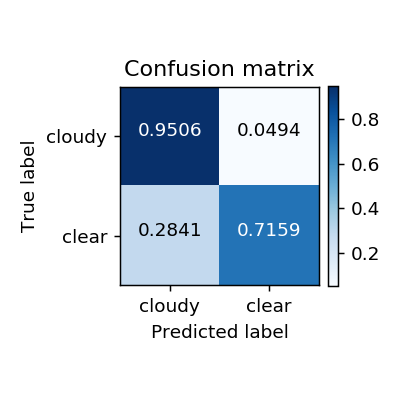

In [10]:
cols = ['abs_diff_ratio stat', 
        'abs_diff_ratio stat window mean', 
        'abs_diff_ratio stat window std', 
        'abs_diff_ratio stat window min', 
        'abs_diff_ratio stat window max', 
        'sky_status']
dt = tree.DecisionTreeClassifier()
dt = fit_model(dt, nsrdb_df, cols)

In [11]:
# tree.export_graphviz(dt, out_file='3_b_abq_default_dt_stat.dot', feature_names=cols[:-1], class_names=['cloudy', 'clear'])
# !dot -Tpng 3_b_abq_default_dt_stat.dot -o 3_b_abq_default_dt_stat.png

In [12]:
# Image('3_b_abq_default_dt_stat.png')

Tree is overly complex and difficult to interpret.  Will start by limiting the depth of the tree (using cross val).

### Max depth tree

<IPython.core.display.Javascript object>


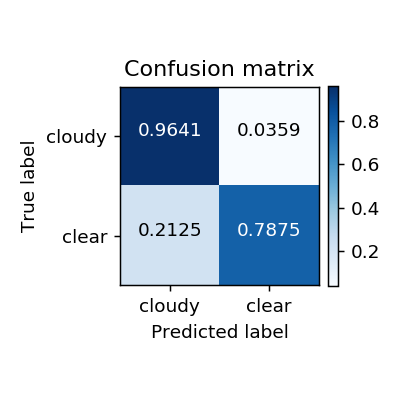

In [13]:
# cols = ['abs_diff_ratio stat', 'abs_diff_ratio stat window mean', 'abs_diff_ratio stat window std', 'sky_status']
param_grid = {'max_depth': [i for i in range(2, 21)]}
dt = tree.DecisionTreeClassifier()
clf_cv = fit_model_cv_grid(dt, nsrdb_df, cols, param_grid)
dt = clf_cv.best_estimator_

In [14]:
print('Optimal max depth: ', dt.max_depth)
MAX_DEPTH = dt.max_depth

Optimal max depth:  7


In [15]:
tree.export_graphviz(dt, out_file='4_srrl_opt_dt_stat.dot', feature_names=[x.replace('abs_diff_ratio stat', '') for x in cols[:-1]], class_names=['cloudy', 'clear'], filled=True)
!dot -Tpng 4_srrl_opt_dt_stat.dot -o 4_srrl_opt_dt_stat.png

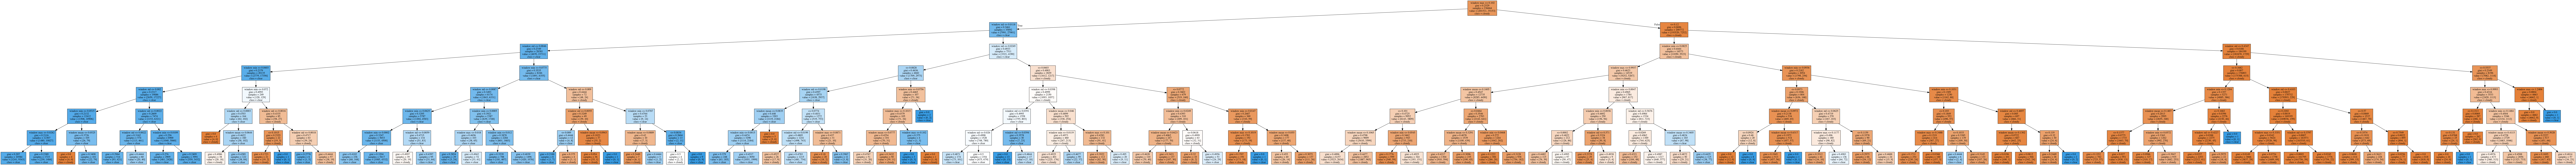

In [16]:
Image('4_srrl_opt_dt_stat.png')

<IPython.core.display.Javascript object>


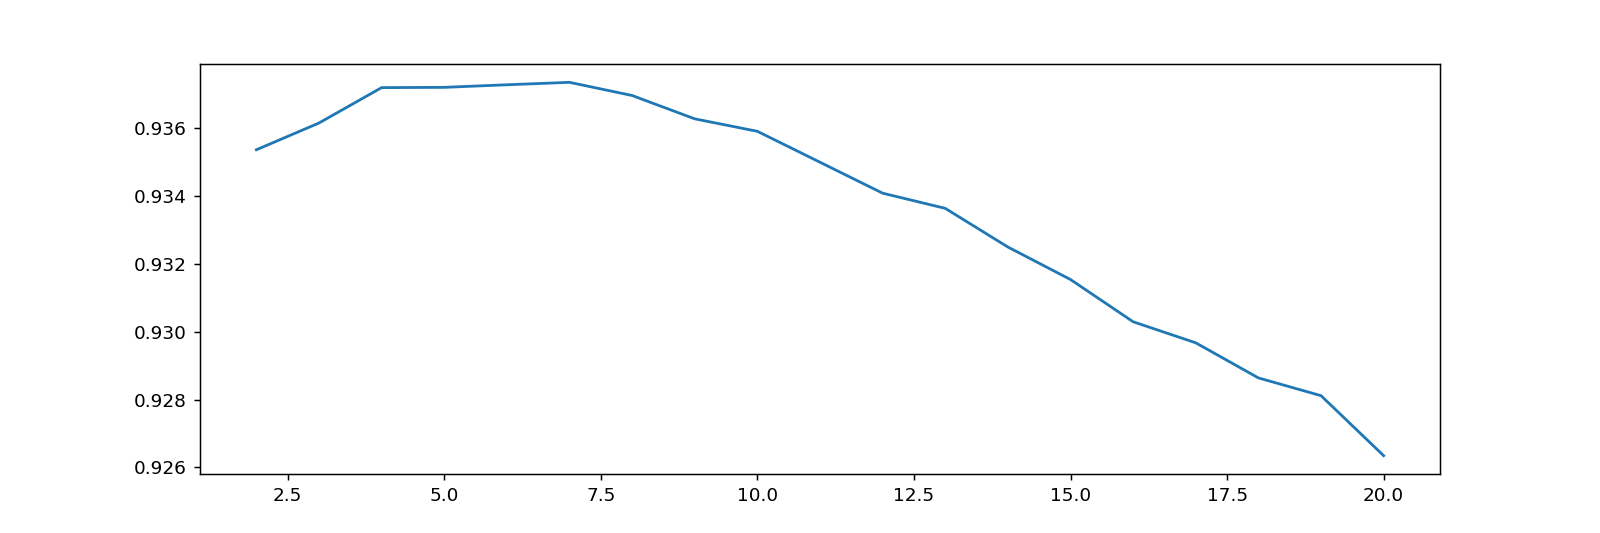

In [17]:
scores = clf_cv.cv_results_['mean_test_score']
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(list(range(2, 21)), scores)

## Test on NSRDB data

In [18]:
train_df = nsrdb_df[nsrdb_df.index < '01-01-2015']
test_df = nsrdb_df[nsrdb_df.index >= '01-01-2015']

In [19]:
# cols = ['GHI', 'Clearsky GHI stat', 'abs_diff_ratio stat', 'sky_status']
# cols = ['abs_diff_ratio stat', 'abs_diff_ratio stat window mean', 'abs_diff_ratio stat window std', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [20]:
predicted_clear = dt.predict(test_df[cols[:-1]])

<IPython.core.display.Javascript object>


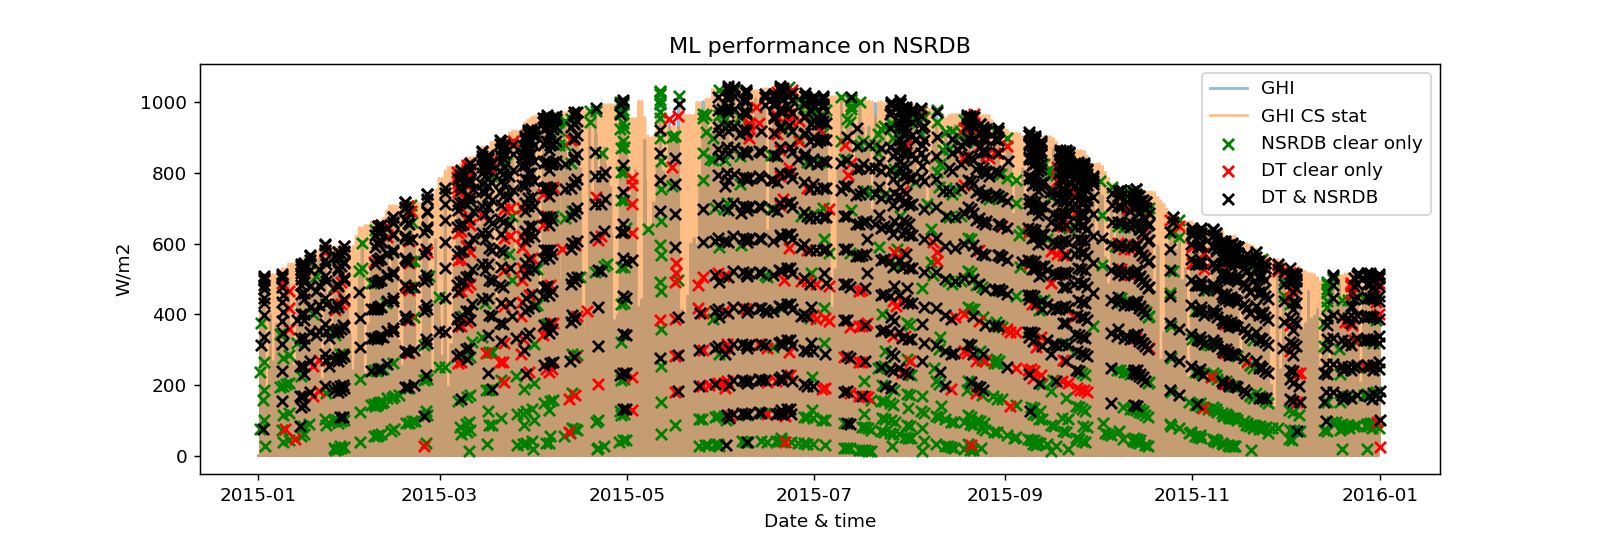

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df[~(predicted_clear) & (test_df['sky_status'] == 1)].index, 
                test_df[~(predicted_clear) & (test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)].index, 
                test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['sky_status'] == 1) & (predicted_clear)].index,
                test_df[(test_df['sky_status'] == 1) & (predicted_clear)]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


<IPython.core.display.Javascript object>


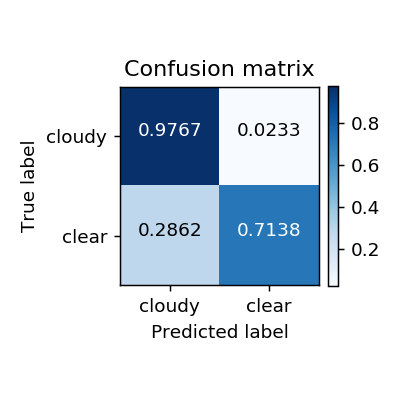

In [22]:
conf_mat = metrics.confusion_matrix(test_df['sky_status'], predicted_clear)
utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])

DT missing early morning and late evenings again.  In general though, the performance is very good.  There are limited cases where the DT detection looks incorrect. 

## Test on ground data

## First run

In [23]:
train_df = nsrdb_df.copy()
test_df = ground_df# [ground_df.index >= '10-01-2015'].copy()
# test_df = ground_df.loc[intersection]

In [24]:
# cols = ['GHI', 'Clearsky GHI stat', 'abs_diff_ratio stat', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [25]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

In [26]:
intersection = test_df.index.intersection(train_df.index)
train_df = train_df.loc[intersection]
test_df = test_df.loc[intersection]

<IPython.core.display.Javascript object>


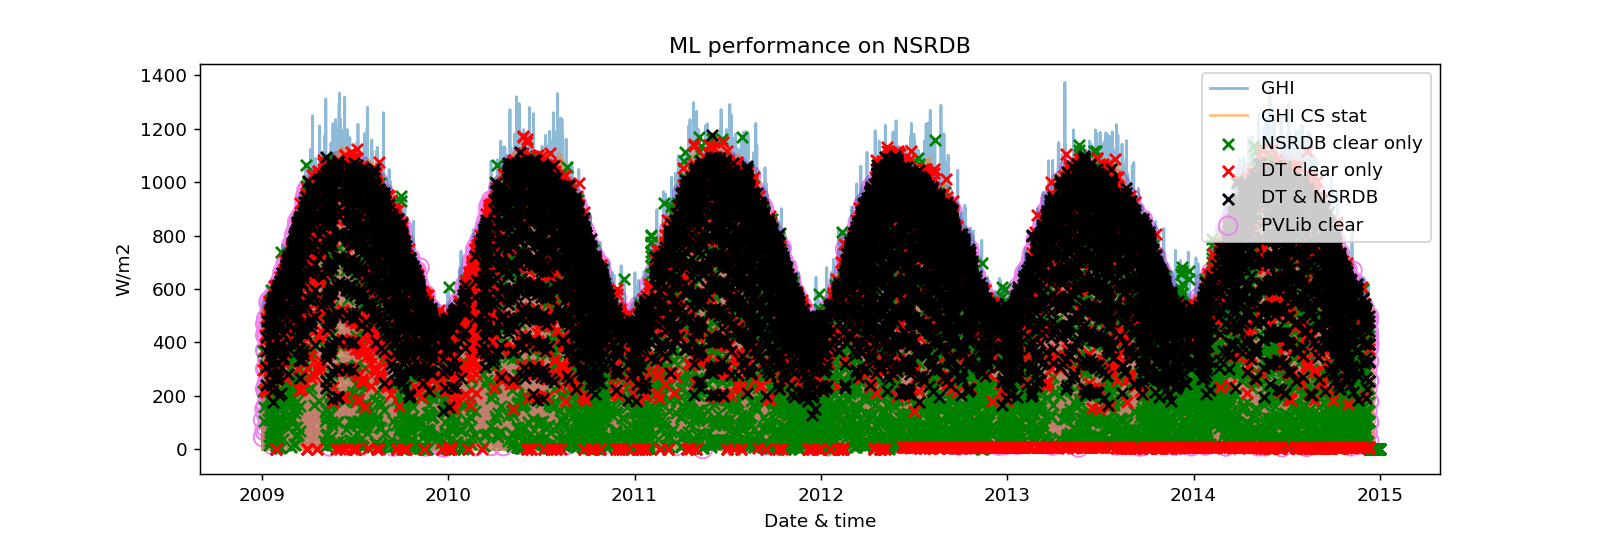

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

p6 = ax.scatter(test_df[test_df['sky_status'] == True].index,
                test_df[test_df['sky_status'] == True]['GHI'],
                marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


<IPython.core.display.Javascript object>


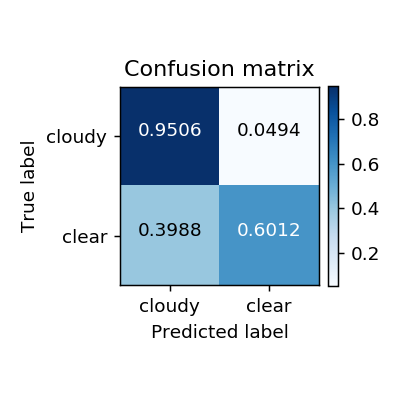

In [28]:
conf_mat = metrics.confusion_matrix(train_df['sky_status'], test_df['dt_clear'])
utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])

In [29]:
dt.feature_importances_

array([ 0.0993,  0.0032,  0.0387,  0.0119,  0.8468])

## Repeat on 1 min data

In [30]:
ground_df = pd.read_pickle('./srrl_ground_df.pkl')

In [31]:
ground_df = ground_df# [(ground_df.index >= '10-01-2015') & (ground_df.index < '01-01-2016')]

In [32]:
window = 20
ground_df['abs_diff_ratio stat window mean'] = ground_df['abs_diff_ratio stat'].rolling(window, center=True).mean().fillna(0)
ground_df['abs_diff_ratio stat window std'] = ground_df['abs_diff_ratio stat'].rolling(window, center=True).std().fillna(0)
ground_df['abs_diff_ratio stat window max'] = ground_df['abs_diff_ratio stat'].rolling(window, center=True).max().fillna(0)
ground_df['abs_diff_ratio stat window min'] = ground_df['abs_diff_ratio stat'].rolling(window, center=True).min().fillna(0)

In [33]:
test_df = ground_df

In [34]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

<IPython.core.display.Javascript object>


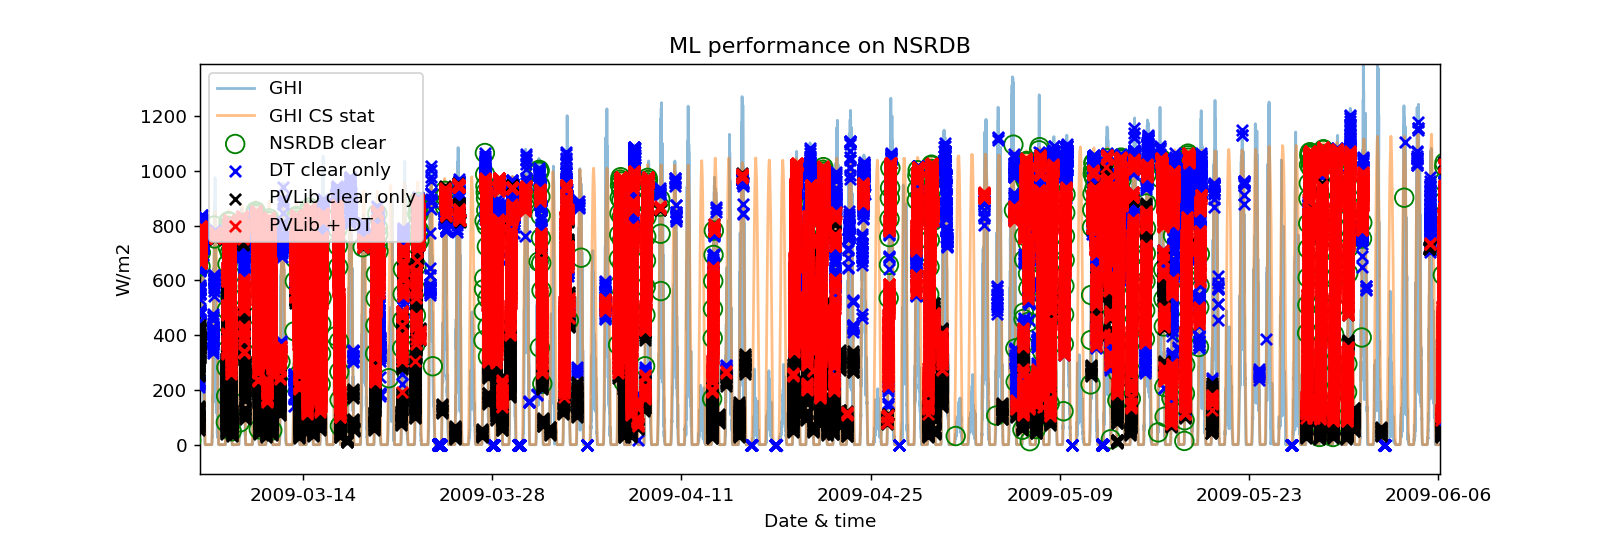

In [35]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI stat'], label='GHI CS stat', alpha=.5)

p3 = ax.scatter(test_df.loc[train_df.index][(train_df['sky_status'])].index,
                test_df.loc[train_df.index][(train_df['sky_status'])]['GHI'],
                marker='o', edgecolor='green', facecolor='none', label='NSRDB clear', zorder=10, s=100)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~test_df['sky_status']].index,
                test_df[(test_df['dt_clear'] == 1) & ~test_df['sky_status']]['GHI'],
                marker='x', color='blue', label='DT clear only', zorder=10)

p4 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & test_df['sky_status']].index,
                test_df[~(test_df['dt_clear'] == 1) & test_df['sky_status']]['GHI'],
                marker='x', color='black', label='PVLib clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & test_df['sky_status']].index,
                test_df[(test_df['dt_clear'] == 1) & test_df['sky_status']]['GHI'],
                marker='x', color='red', label='PVLib + DT', zorder=10)

# p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
#                 test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
#                 marker='x', color='black', label='DT & NSRDB', zorder=10)

# p6 = ax.scatter(test_df[test_df['sky_status']].index,
#                 test_df[test_df['sky_status']]['GHI'],
#                 marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')
